In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import glob
import math
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time

In [2]:
import pandas as pd
pd.read_csv('DatosFinales.csv')

,Unnamed: 0,Fecha,Hora,Potencia [kW],Irradiacion [W/m2],Temperatura de modulos[C]
0,0,1/10/2019,7:00,4.37,57.08,15.13
1,1,1/10/2019,7:05,5.71,73.87,15.49
2,2,1/10/2019,7:10,7.76,101.24,16.13
3,3,1/10/2019,7:15,11.23,144.43,17.19
4,4,1/10/2019,7:20,14.76,198.53,18.62
...,...,...,...,...,...,...
54955,54955,31/12/2020,16:35,0.10,8.75,14.15
54956,54956,31/12/2020,16:40,0.05,7.03,14.15
54957,54957,31/12/2020,16:45,0.10,8.97,14.20
54958,54958,31/12/2020,16:50,0.18,11.11,14.19


In [295]:
abril = pd.read_csv('DatosFinales.csv').drop('Unnamed: 0',axis = 1)
#abril = abril[['Fecha','Hora','Energia [kWh]','Irradiacion [Wh/m2]','Temperatura de modulos [C]']]
abril = abril[['Fecha','Hora','Potencia [kW]','Irradiacion [W/m2]','Temperatura de modulos[C]']]
abril['Time'] = pd.to_datetime(abril['Fecha']+' '+abril['Hora'])
abril = abril.set_index('Time')
abril = abril. resample('60T').mean()
abril.dropna(inplace = True)
abril.set_index(np.array(range(4580)),inplace = True)
abril

,Potencia [kW],Irradiacion [W/m2],Temperatura de modulos[C]
0,15.220000,242.950833,23.139167
1,34.786667,522.285000,35.152500
2,36.830000,503.754167,31.743333
3,30.043333,377.405833,28.122500
4,19.769167,242.401667,26.493333
...,...,...,...
4575,5.960000,138.326667,25.977500
4576,3.046667,75.204167,18.377500
4577,0.524167,19.589167,14.272500
4578,0.206667,11.668333,13.439167


In [321]:
abril.loc[abril['Potencia [kW]'] < 1 , 'Potencia [kW]'] = 1
abril

,Potencia [kW],Irradiacion [W/m2],Temperatura de modulos[C]
0,15.220000,242.950833,23.139167
1,34.786667,522.285000,35.152500
2,36.830000,503.754167,31.743333
3,30.043333,377.405833,28.122500
4,19.769167,242.401667,26.493333
...,...,...,...
4575,5.960000,138.326667,25.977500
4576,3.046667,75.204167,18.377500
4577,1.000000,19.589167,14.272500
4578,1.000000,11.668333,13.439167


In [261]:
abril  = pd.read_csv('Datos cada 20 min promedio movil 5.csv').dropna(axis = 1)
abril[0:60]

,Time,Potencia [kW],Irradiacion [W/m2],Temperatura de modulos[C]
0,2019-01-10 07:00:00,25.003333,94.1550,15.9850
1,2019-01-10 07:20:00,25.600357,352.3375,24.5925
2,2019-01-10 07:40:00,27.264375,282.3600,28.8400
3,2019-01-10 08:00:00,28.945556,557.1875,32.0300
4,2019-01-10 08:20:00,29.151750,515.4425,34.4150
5,2019-01-10 08:40:00,29.159318,494.2250,39.0125
6,2019-01-10 09:00:00,31.215682,389.1675,28.7375
7,2019-01-10 09:20:00,31.247955,533.3525,32.9075
8,2019-01-10 09:40:00,31.239545,588.7425,33.5850
9,2019-01-10 10:00:00,29.817727,388.1350,29.5050


## Por hora

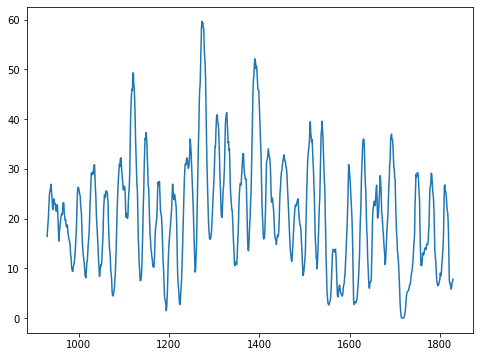

In [156]:
#abril['Energia [kWh]'][930:1830].plot(figsize = (11,8))
abril['Potencia [kW]'][930:1830].plot(figsize = (8,6))

### Función de auto correlación y de autocorrelación parcial

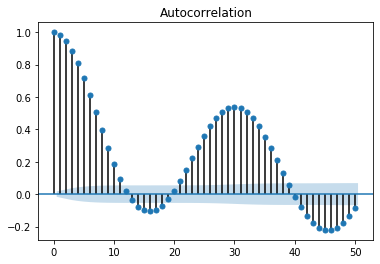

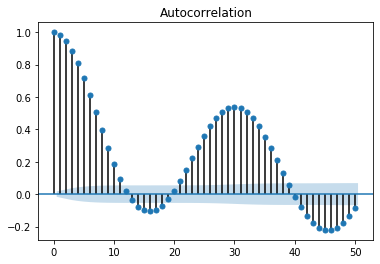

In [262]:
#plot_acf(abril['Energia [kWh]'], lags =120)
plot_acf(abril['Potencia [kW]'], lags =50)

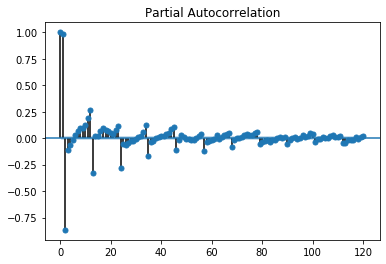

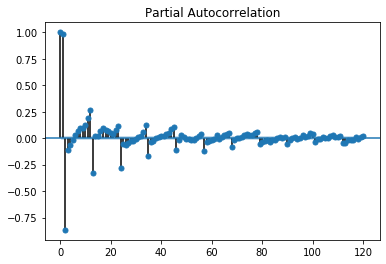

In [263]:
#plot_pacf(abril['Energia [kWh]'], lags =120)
plot_pacf(abril['Potencia [kW]'], lags =120)

### Se observa que los datos a tratar son no estacionarios, se procede a realizar la conversión a datos estacionarios

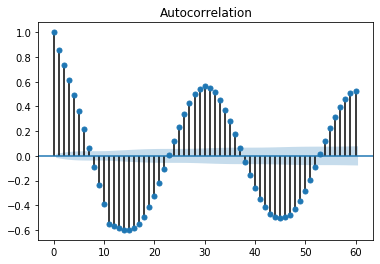

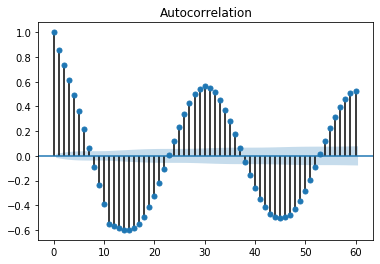

In [264]:
k=1
first_diff = abril['Potencia [kW]'].diff(1)
#first_diff = first_diff.diff(k)
plot_acf(first_diff[k+1:], lags = 60)

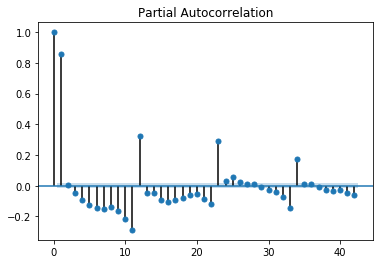

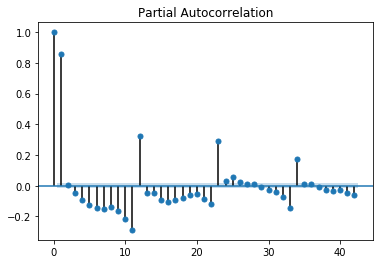

In [265]:
plot_pacf(first_diff[k+1:])

## Entrenamiento del modelo SARIMAX

#### Datos de entrenamiento y de prueba

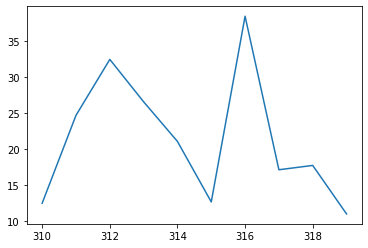

In [353]:
train_data = abril['Potencia [kW]'][310:610]
test_data = abril['Potencia [kW]'][610:920]
plt.plot(abril['Potencia [kW]'][310:320])

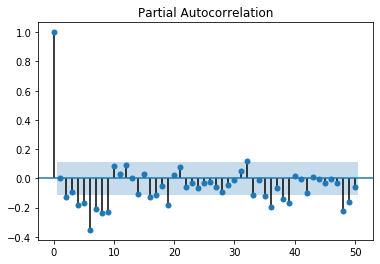

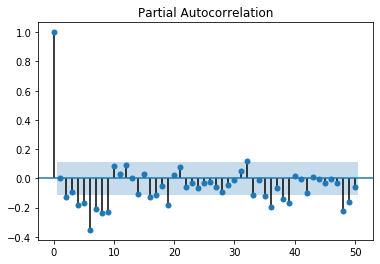

In [354]:
plot_pacf(train_data.diff()[1:], lags = 50)

In [355]:
train_data = np.log(train_data.values)
test_data = np.log(test_data.values)

In [356]:
test_data

array([2.31418423, 2.93478729, 3.42518514, 2.34340709, 1.90558406,
       2.57432831, 3.20595943, 1.00947745, 1.60810369, 2.336906  ,
       2.95143201, 3.56936836, 3.78267333, 4.14658116, 3.92971556,
       3.74431416, 3.04622733, 3.20528387, 2.8897234 , 1.54187259,
       1.87116095, 3.512366  , 3.63543472, 3.67547755, 3.55518138,
       3.61386402, 3.30789352, 2.04424605, 1.47113324, 0.21980465,
       3.16663471, 3.74541731, 4.07218416, 3.88068713, 3.83177055,
       3.45933525, 2.97165301, 2.59026717, 2.01468077, 1.28532235,
       1.96197096, 2.32442812, 3.0465838 , 3.37354066, 2.86562359,
       3.54690778, 3.43830582, 3.02241477, 2.1164563 , 2.0023805 ,
       2.13150017, 2.70760566, 2.51250831, 3.26820553, 3.57433336,
       3.74856246, 3.27940632, 2.79152292, 2.61709165, 1.88200635,
       2.43609565, 3.48971688, 3.51643397, 3.0941437 , 3.27285883,
       3.31160692, 3.13342686, 2.92222028, 2.9042564 , 2.18154676,
       2.83409531, 3.54088686, 3.79498344, 3.99060311, 3.49506

#### Pruebas 

Se realiza el ajuste de diferentes modelos fijando un valor para el parámetro SAR y SMA y realizando la prueba de estos con diferentes valores de AR y MA.

In [363]:
my_order = (4,1,5)
my_seasonal_order = (1, 1, 1, 10)

model = SARIMAX(train_data/np.max(train_data), order = my_order, seasonal_order=my_seasonal_order)

In [364]:
# Ajuste del modelo
start = time()
model_fit = model.fit(disp = True, verbose = True)
end = time()
print('Tiempo de ajuste del modelo: ',end-start)

C:\Users\USUARIO\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Tiempo de ajuste del modelo:  32.39997982978821


In [365]:
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  300
Model:             SARIMAX(4, 1, 5)x(1, 1, [1], 10)   Log Likelihood                 127.961
Date:                              Sat, 06 Feb 2021   AIC                           -231.923
Time:                                      22:16:33   BIC                           -187.925
Sample:                                           0   HQIC                          -214.293
                                              - 300                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0395      0.894     -0.044      0.965      -1.791       1.712
ar.L2         -0.53

In [376]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data[0:10]))
#predictions = pd.Series(predictions, index=test_data.index)

In [377]:
predictions= predictions*np.max(train_data)
predictions

array([1.926576  , 2.41633991, 2.80269217, 2.78514528, 3.06956388,
       2.80849629, 2.27539535, 2.03508134, 1.75342813, 1.35509168])

In [379]:
rmse=math.sqrt(mean_squared_error(test_data[0:10],predictions))
rmse

0.7289878621476105

Text(0, 0.5, 'Error')

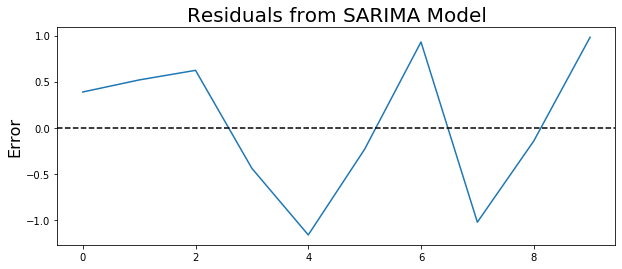

In [381]:
residuals = test_data[0:10] - predictions
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

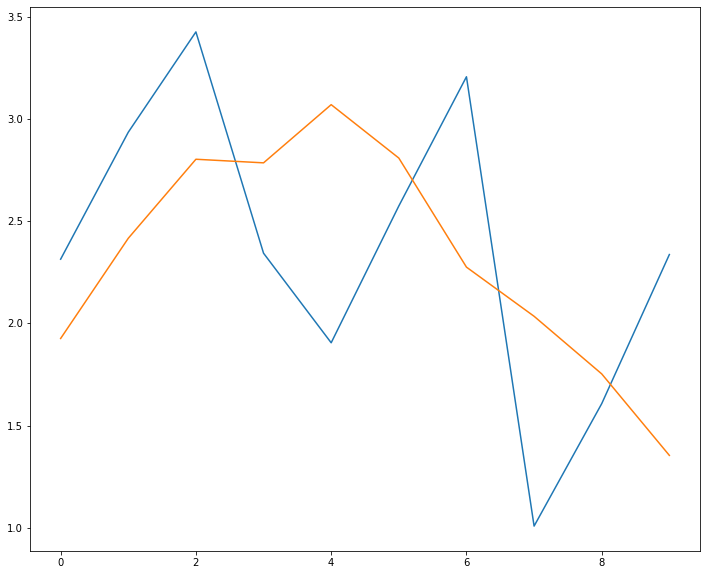

In [383]:
plt.figure(figsize = (12,10))
plt.plot(test_data[0:10])
plt.plot(predictions)

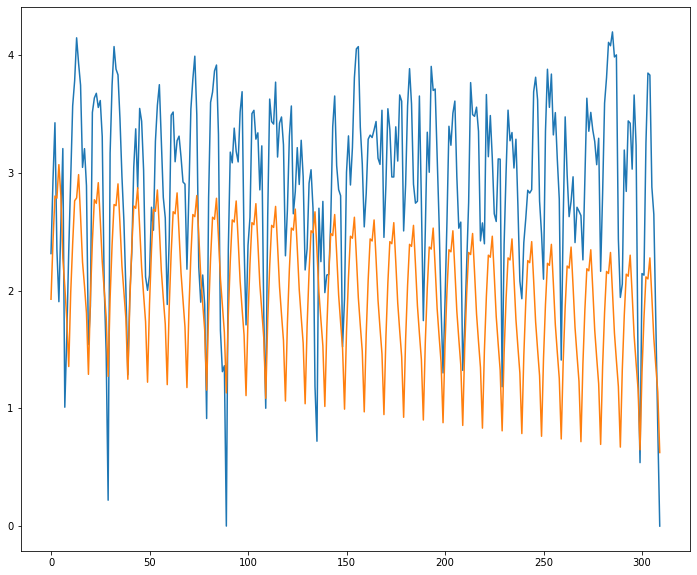

In [371]:
plt.figure(figsize = (12,10))
plt.plot(test_data)
plt.plot(predictions)

In [372]:
train_data

array([2.52299157, 3.20680324, 3.48093235, 3.28047252, 3.04788978,
       2.53719598, 3.65074482, 2.84049072, 2.8750701 , 2.39546809,
       3.17919901, 3.22681093, 3.04725679, 2.94118809, 2.86737793,
       2.91867123, 2.92195117, 2.34028221, 2.50803978, 1.59820843,
       2.34899147, 2.84019869, 3.146556  , 3.42672975, 3.44773634,
       2.58336842, 2.62237127, 2.65798422, 1.89373928, 1.2342595 ,
       2.73733928, 3.26132849, 2.95850624, 3.49784505, 3.63466523,
       3.17871334, 3.3018987 , 2.45057397, 2.20368514, 1.08236998,
       2.5168897 , 2.95173685, 3.12803896, 3.54274517, 2.98904329,
       3.05392256, 2.82918564, 1.13328206, 1.72499625, 0.97926553,
       1.90546011, 2.680165  , 3.34568467, 3.71592702, 3.28069189,
       3.24807858, 3.4630239 , 3.16691564, 3.19232649, 2.56070961,
       3.1937973 , 3.38932159, 3.83287157, 4.15250864, 3.54132158,
       3.80023447, 3.34729836, 2.71629391, 1.836175  , 0.        ,
       2.48442042, 3.18762593, 3.82381091, 3.75609018, 3.36049

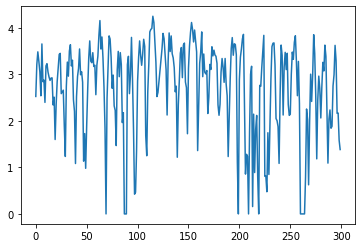

In [373]:
plt.plot(train_data)